In [33]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import contextily as ctx

from utils import init_postgis, get_location_error, crop_route, get_total_distance

In [34]:
matplotlib.rcParams['timezone'] = 'Asia/Singapore'

In [35]:
date = '14-06-2024'

In [36]:
input_dir = f"../data/{date}"
output_dir = f"../metadata/{date}"

In [37]:
start_location = (1.309445687403374, 103.8945458856887)
stop_location = (1.3529034694080613, 103.87632796340252)

In [38]:
init_postgis('gpx_route', input_dir + '/route.gpx')
init_postgis('polar_route', input_dir + '/polar.gpx')
init_postgis('garmin_route', input_dir + '/garmin.gpx')

In [39]:
garmin_df = get_location_error('garmin_route')
garmin_df.head(3)

,time,latitude,longitude,distance_to_route
0,2024-06-14 21:41:45+08:00,1.309434,103.896091,173.964152
1,2024-06-14 21:42:00+08:00,1.309462,103.896110,176.944060
2,2024-06-14 21:42:09+08:00,1.309428,103.896120,176.820596


In [40]:
polar_df = get_location_error('polar_route')
polar_df.head(3)

,time,latitude,longitude,distance_to_route
0,2024-06-14 21:42:22.269000+08:00,1.309432,103.896152,180.229824
1,2024-06-14 21:42:23.270000+08:00,1.309432,103.896152,180.229824
2,2024-06-14 21:42:24.271000+08:00,1.309457,103.896145,180.463732


In [41]:
garmin_df = crop_route(garmin_df, start_location, stop_location, 200)
garmin_df.head(3)

,time,latitude,longitude,distance_to_route,start_distance,stop_distance
13,2024-06-14 21:43:21+08:00,1.309501,103.894629,22.406617,11.055872,5213.505613
14,2024-06-14 21:43:26+08:00,1.309361,103.894640,18.568704,14.038920,5228.221104
15,2024-06-14 21:43:33+08:00,1.309173,103.894688,16.854179,34.048641,5249.469379


In [42]:
polar_df = crop_route(polar_df, start_location, stop_location, 600)
polar_df.head(3)

,time,latitude,longitude,distance_to_route,start_distance,stop_distance
62,2024-06-14 21:43:24.271000+08:00,1.309450,103.894612,18.775003,7.336690,5217.955296
63,2024-06-14 21:43:25.271000+08:00,1.309428,103.894615,18.342422,7.927615,5220.306309
64,2024-06-14 21:43:26.271000+08:00,1.309405,103.894617,17.675060,9.071829,5222.754431


In [43]:
desc_polar_df = polar_df['distance_to_route'].describe().to_frame()
desc_polar_df.columns = ['Polar']

desc_garmin_df = garmin_df['distance_to_route'].describe().to_frame()
desc_garmin_df.columns = ['Garmin']

merged_desc = pd.concat([desc_polar_df, desc_garmin_df], axis=1)
merged_desc.to_csv('/tmp/merged_desc.csv')

print(merged_desc)

              Polar       Garmin
count  26849.000000  5806.000000
mean      12.183876    12.559679
std       23.731189    25.999709
min        0.000536     0.001572
25%        2.998031     2.538568
50%        6.166509     5.978562
75%       11.804859    11.510435
max      198.990322   202.455530


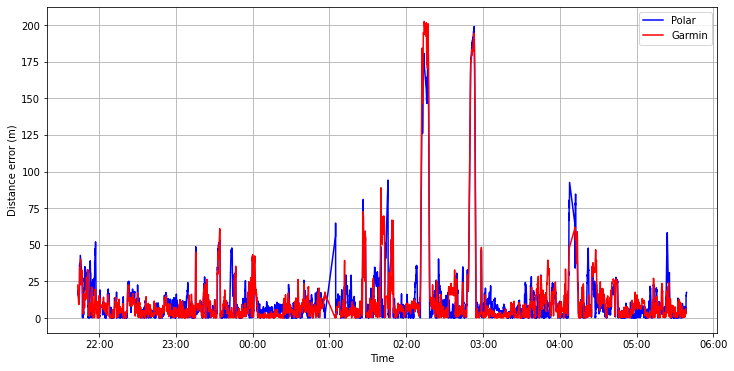

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(polar_df['time'], polar_df['distance_to_route'], color='blue', label='Polar')
plt.plot(garmin_df['time'], garmin_df['distance_to_route'], color='red', label='Garmin')
plt.xlabel('Time')
plt.ylabel('Distance error (m)')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.savefig(output_dir + '/location-error.png', bbox_inches='tight', facecolor='white')

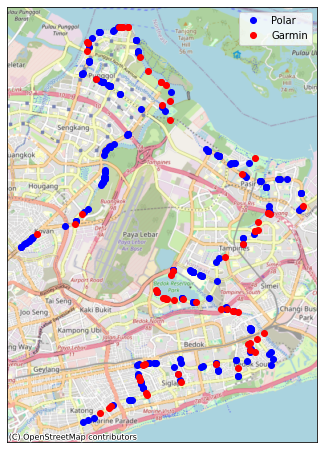

In [44]:
distance_error_threshold = 0.1
filtered_polar_df = polar_df[polar_df['distance_to_route'] <= distance_error_threshold]
filtered_garmin_df = garmin_df[garmin_df['distance_to_route'] <= distance_error_threshold]

plt.figure(figsize=(15, 8))
plt.plot(filtered_polar_df['longitude'], filtered_polar_df['latitude'], 'o', color='blue', label='Polar')
plt.plot(filtered_garmin_df['longitude'], filtered_garmin_df['latitude'], 'o', color='red', label='Garmin')
ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
plt.legend()
plt.xticks([], [])
plt.yticks([], [])
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
plt.savefig(output_dir + '/' + 'accurate-location.png', facecolor='white', bbox_inches='tight', pad_inches=0)

In [29]:
polar_df = get_total_distance(polar_df)
polar_df.iloc[-1]['accumulated_distance']

61067.96255906263

In [30]:
garmin_df = get_total_distance(garmin_df)
garmin_df.iloc[-1]['accumulated_distance']

58925.812995617845

In [31]:
polar_df.iloc[-1]['accumulated_distance'] - garmin_df.iloc[-1]['accumulated_distance']

2142.1495634447856